In [82]:
import tvm
from tvm import topi
from tvm import autotvm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [2]:
records = [r for r in autotvm.record.load_from_file('resnet-18.log.tmp')]
costs = [r[1].costs[0] for r in records]

In [11]:
good_idx = []
for i in range(len(records)):
    inp, res = records[i]
    if res.error_no != 0:
        continue
    good_idx.append(i)

In [140]:
def extract_bank_conf(idx):
    filename = "resnet-18.log.tmp.benchmark/{}.log".format(idx)
    ans = {}
    with open(filename) as fh:
        txt = fh.readlines()
        #print(filename)
        for i in range(len(txt)):
            line = txt[i]
            if "Kernel" in line:
                for j in range(i+1, i+5):
                    data = txt[j].split()[1:]
                    if data[0] not in ans:
                        ans[data[0]] = 0.0
                    ans[data[0]] += float(data[-1])
    if len(ans.keys()) != 4:
        raise Exception("wrong")
    #print(len(ans.keys()))
    return ans

In [141]:
bank_conflict_data = []
for idx in good_idx:
    try:
        res = extract_bank_conf(idx)
    except Exception as e:
        continue
    bank_conflict_data.append((idx, res))

In [142]:
workloads = defaultdict(list)
for (idx, bank_data) in bank_conflict_data:
    inp, res = records[idx]
    workloads[inp.task.workload].append((idx, bank_data))

In [143]:
workload_keys = list(workloads.keys())

In [144]:
len(good_idx)

13103

('conv2d_nchw.cuda', ('TENSOR', (1, 256, 14, 14), 'float32'), ('TENSOR', (512, 256, 1, 1), 'float32'), (2, 2), (0, 0, 0, 0), (1, 1), 'float32')
num samples = 962


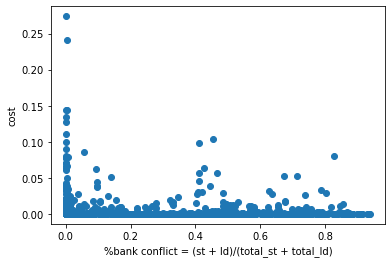

('conv2d_nchw.cuda', ('TENSOR', (1, 128, 28, 28), 'float32'), ('TENSOR', (256, 128, 1, 1), 'float32'), (2, 2), (0, 0, 0, 0), (1, 1), 'float32')
num samples = 629


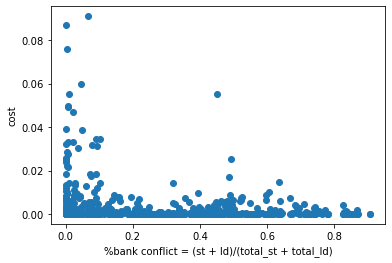

('conv2d_nchw.cuda', ('TENSOR', (1, 64, 56, 56), 'float32'), ('TENSOR', (128, 64, 1, 1), 'float32'), (2, 2), (0, 0, 0, 0), (1, 1), 'float32')
num samples = 1128


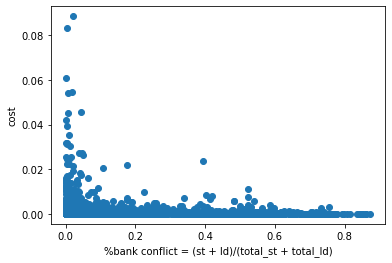

('conv2d_nchw.cuda', ('TENSOR', (1, 64, 56, 56), 'float32'), ('TENSOR', (64, 64, 1, 1), 'float32'), (1, 1), (0, 0, 0, 0), (1, 1), 'float32')
num samples = 534


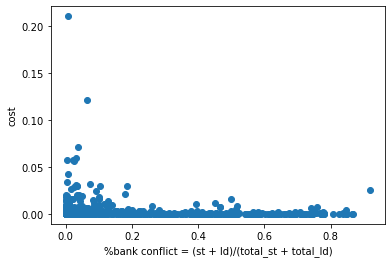

('conv2d_nchw.cuda', ('TENSOR', (1, 3, 224, 224), 'float32'), ('TENSOR', (64, 3, 7, 7), 'float32'), (2, 2), (3, 3, 3, 3), (1, 1), 'float32')
num samples = 444


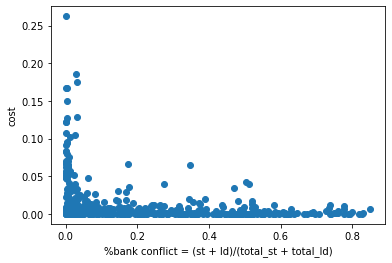

('conv2d_nchw_winograd.cuda', ('TENSOR', (1, 64, 56, 56), 'float32'), ('TENSOR', (64, 64, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'float32')
num samples = 793


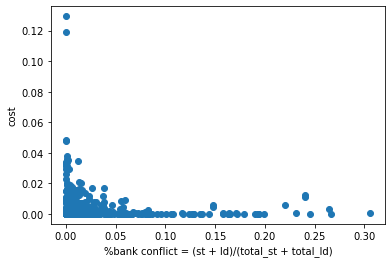

('conv2d_nchw.cuda', ('TENSOR', (1, 64, 56, 56), 'float32'), ('TENSOR', (64, 64, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'float32')
num samples = 454


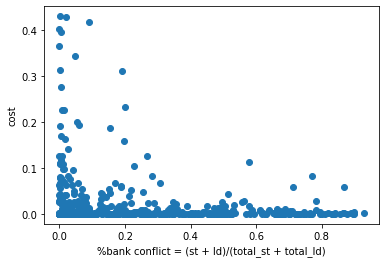

('conv2d_nchw.cuda', ('TENSOR', (1, 64, 56, 56), 'float32'), ('TENSOR', (128, 64, 3, 3), 'float32'), (2, 2), (1, 1, 1, 1), (1, 1), 'float32')
num samples = 620


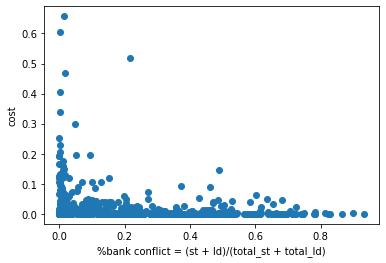

('conv2d_nchw_winograd.cuda', ('TENSOR', (1, 128, 28, 28), 'float32'), ('TENSOR', (128, 128, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'float32')
num samples = 853


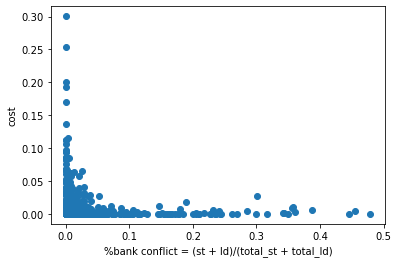

('conv2d_nchw.cuda', ('TENSOR', (1, 128, 28, 28), 'float32'), ('TENSOR', (128, 128, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'float32')
num samples = 826


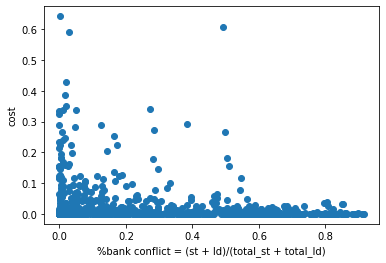

('conv2d_nchw.cuda', ('TENSOR', (1, 128, 28, 28), 'float32'), ('TENSOR', (256, 128, 3, 3), 'float32'), (2, 2), (1, 1, 1, 1), (1, 1), 'float32')
num samples = 707


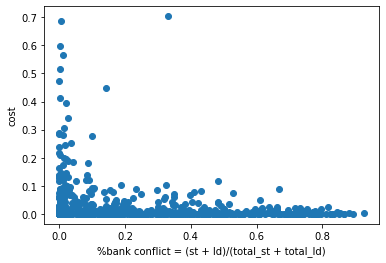

('conv2d_nchw_winograd.cuda', ('TENSOR', (1, 256, 14, 14), 'float32'), ('TENSOR', (256, 256, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'float32')
num samples = 1069


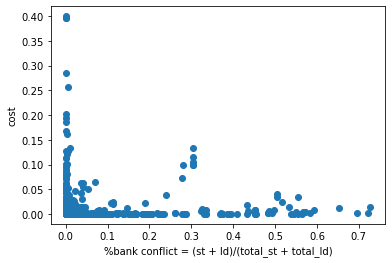

('conv2d_nchw.cuda', ('TENSOR', (1, 256, 14, 14), 'float32'), ('TENSOR', (256, 256, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'float32')
num samples = 920


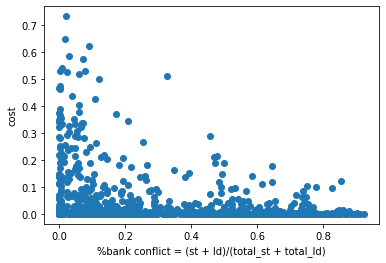

('conv2d_nchw.cuda', ('TENSOR', (1, 256, 14, 14), 'float32'), ('TENSOR', (512, 256, 3, 3), 'float32'), (2, 2), (1, 1, 1, 1), (1, 1), 'float32')
num samples = 657


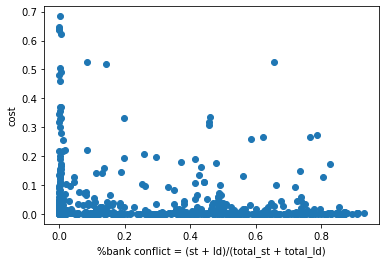

('conv2d_nchw_winograd.cuda', ('TENSOR', (1, 512, 7, 7), 'float32'), ('TENSOR', (512, 512, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'float32')
num samples = 1739


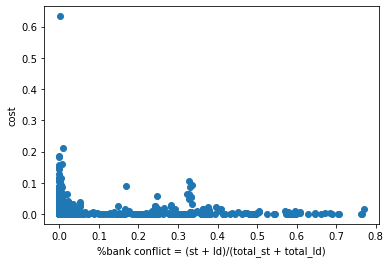

('conv2d_nchw.cuda', ('TENSOR', (1, 512, 7, 7), 'float32'), ('TENSOR', (512, 512, 3, 3), 'float32'), (1, 1), (1, 1, 1, 1), (1, 1), 'float32')
num samples = 764


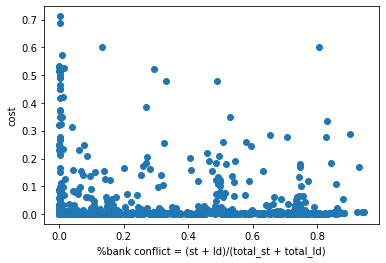

In [162]:
def calc_conflict(conflict):
    ld = conflict['shared_ld_bank_conflict']
    st = conflict['shared_st_bank_conflict']
    total_ld = conflict['shared_ld_transactions']
    total_st = conflict['shared_st_transactions']
    if (total_ld + total_st) == 0:
        return 0
    return (ld + st) / (total_ld + total_st)

def plot(data):
    cost, conflict = np.zeros(len(data)), np.zeros(len(data))
    for i in range(len(data)):
        idx = data[i][0]
        cost[i] = costs[idx]
        conflict[i] = calc_conflict(data[i][1])
    return cost, conflict

for key in workload_keys:
    print(key)
    x, y = plot(workloads[key])
    print("num samples = {}".format(len(x)))
    plt.scatter(y, x)
    plt.xlabel("%bank conflict = (st + ld)/(total_st + total_ld)")
    #plt.xlabel("total number of bank conflict = st + ld")
    #plt.xlabel("total number of bank conflict = total_st + total_ld")
    plt.ylabel("cost")
    plt.show()

In [147]:
len(workload_keys)

16

In [108]:
a = {}

In [111]:
a['a'] = 1

In [154]:
good_idx

[1,
 3,
 5,
 6,
 7,
 9,
 11,
 12,
 14,
 17,
 18,
 19,
 20,
 21,
 24,
 25,
 27,
 28,
 29,
 30,
 31,
 32,
 35,
 36,
 40,
 41,
 42,
 44,
 45,
 47,
 48,
 49,
 52,
 53,
 54,
 56,
 59,
 61,
 64,
 66,
 67,
 68,
 69,
 70,
 74,
 75,
 77,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 90,
 91,
 92,
 93,
 94,
 96,
 97,
 98,
 100,
 101,
 103,
 104,
 105,
 107,
 108,
 109,
 110,
 111,
 115,
 116,
 117,
 118,
 120,
 121,
 122,
 124,
 125,
 126,
 128,
 131,
 132,
 133,
 134,
 137,
 138,
 140,
 141,
 142,
 143,
 144,
 145,
 147,
 149,
 150,
 154,
 155,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 165,
 166,
 168,
 171,
 172,
 173,
 174,
 176,
 180,
 183,
 185,
 187,
 191,
 192,
 198,
 199,
 202,
 203,
 204,
 207,
 208,
 209,
 210,
 213,
 214,
 215,
 218,
 219,
 221,
 222,
 224,
 225,
 227,
 228,
 230,
 231,
 234,
 235,
 237,
 238,
 239,
 240,
 243,
 245,
 246,
 247,
 250,
 251,
 252,
 253,
 255,
 257,
 258,
 259,
 260,
 261,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 277,
 279,
